In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pandas as pd
from statsmodels.graphics import tsaplots as tsplt

In [2]:
# First we'll simulate the synthetic data
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,
                           harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration # Pad for burn in
    series = np.zeros(total_timesteps) 
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:] # Discard burn in

    return wanted_series

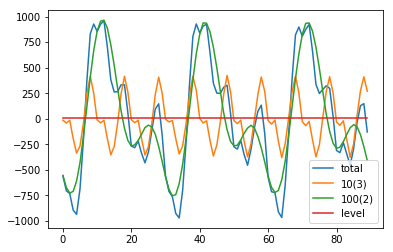

In [3]:
## simulate some data 
duration = 30 * 3
periodicities = [10, 30]
num_harmonics = [3, 2]
std = np.array([2, 3])
np.random.seed(8678309)

terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
series = pd.Series(np.sum(terms, axis=0))
df = pd.DataFrame(data={'total': series,
                        '10(3)': terms[0],
                        '100(2)': terms[1],
                        'level':terms[2]})
h1, = plt.plot(df['total'])
h2, = plt.plot(df['10(3)'])
h3, = plt.plot(df['100(2)'])
h4, = plt.plot(df['level'])
plt.legend(['total','10(3)','100(2)', 'level'])

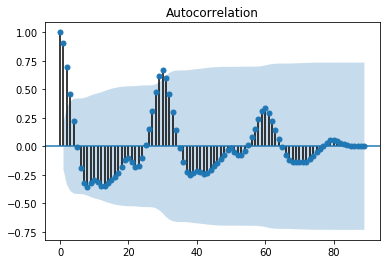

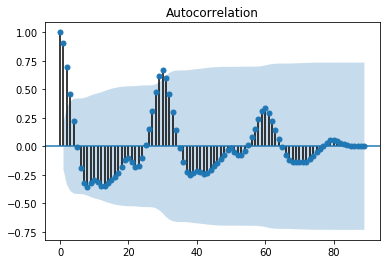

In [9]:
tsplt.plot_acf(df['total'])

                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                   90
Model:                                fixed intercept   Log Likelihood                -512.678
                    + stochastic freq_seasonal(10(3))   AIC                           1029.357
                   + stochastic freq_seasonal(100(2))   BIC                           1034.096
Date:                                Thu, 14 Nov 2019   HQIC                          1031.255
Time:                                        11:02:49                                         
Sample:                                             0                                         
                                                 - 90                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

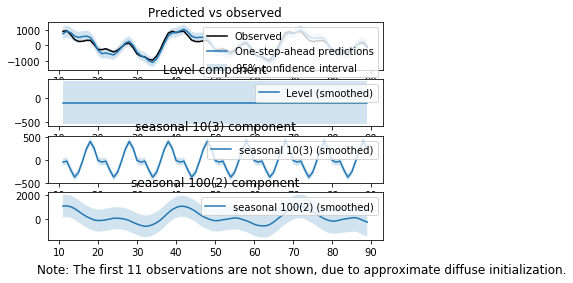

In [5]:
model = sm.tsa.UnobservedComponents(series.values, 
                                    level='fixed intercept', 
                                    freq_seasonal=[{'period': 10,
                                                    'harmonics': 3},
                                                   {'period': 100,
                                                    'harmonics': 2}])
res_f = model.fit(disp=False)
print(res_f.summary())
# The first state variable holds our estimate of the intercept
print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_plt = res_f.plot_components()

                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                   90
Model:                                fixed intercept   Log Likelihood                -496.254
                            + stochastic seasonal(10)   AIC                            996.507
                   + stochastic freq_seasonal(100(2))   BIC                           1001.169
Date:                                Tue, 12 Nov 2019   HQIC                           998.370
Time:                                        10:19:50                                         
Sample:                                             0                                         
                                                 - 90                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

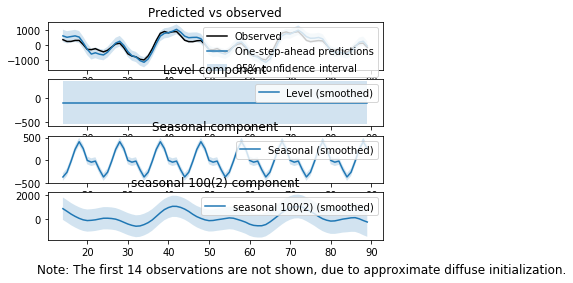

In [40]:
model = sm.tsa.UnobservedComponents(series, 
                                    level='fixed intercept', 
                                    seasonal=10,
                                    freq_seasonal=[{'period': 100,
                                                    'harmonics': 2}])
res_tf = model.fit(disp=False)
print(res_tf.summary())
# The first state variable holds our estimate of the intercept
print("fixed intercept estimated as {0:.3f}".format(res_tf.smoother_results.smoothed_state[0,-1:][0]))

res_plt2 = res_tf.plot_components()


/Users/Myworld/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2199: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)


                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                   90
Model:                                 fixed intercept   Log Likelihood                   0.000
                   + stochastic freq_seasonal(100(50))   AIC                              2.000
Date:                                 Tue, 12 Nov 2019   BIC                                nan
Time:                                         10:19:51   HQIC                               nan
Sample:                                              0                                         
                                                  - 90                                         
Covariance Type:                                   opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

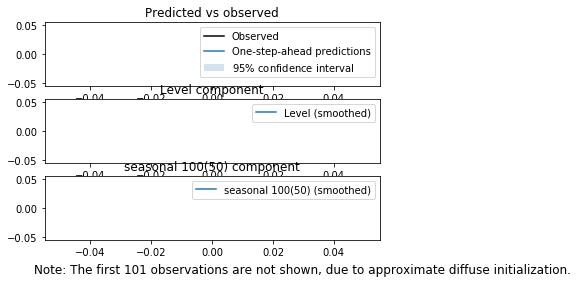

In [41]:
model = sm.tsa.UnobservedComponents(series, 
                                    level='fixed intercept', 
                                    freq_seasonal=[{'period': 100}])
res_lf = model.fit(disp=False)
print(res_lf.summary())
# The first state variable holds our estimate of the intercept
print("fixed intercept estimated as {0:.3f}".format(res_lf.smoother_results.smoothed_state[0,-1:][0]))

res_plt3 = res_lf.plot_components()

/Users/Myworld/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2199: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)


                            Unobserved Components Results                             
Dep. Variable:                              y   No. Observations:                   90
Model:                        fixed intercept   Log Likelihood                   0.000
                   + stochastic seasonal(100)   AIC                              2.000
Date:                        Tue, 12 Nov 2019   BIC                                nan
Time:                                10:19:52   HQIC                               nan
Sample:                                     0                                         
                                         - 90                                         
Covariance Type:                          opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal  2.176e+05         -0       -inf 

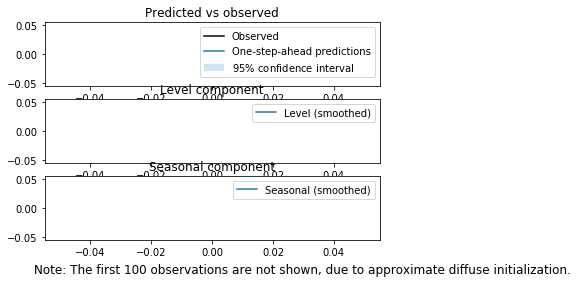

In [42]:
model = sm.tsa.UnobservedComponents(series,
                                    level='fixed intercept',
                                    seasonal=100)
res_lt = model.fit(disp=False)
print(res_lt.summary())
# The first state variable holds our estimate of the intercept
print("fixed intercept estimated as {0:.3f}".format(res_lt.smoother_results.smoothed_state[0,-1:][0]))

res_plt4 = res_lt.plot_components()


In [43]:
# Assign better names for our seasonal terms
true_seasonal_10_3 = terms[0]
true_seasonal_100_2 = terms[1]
true_sum = true_seasonal_10_3 + true_seasonal_100_2

Text(0.5, 1.0, 'Seasonal 10(3) component')

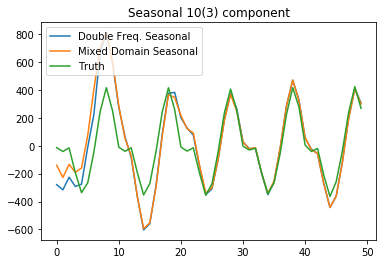

In [44]:
time_s = np.s_[:50]  # After this they basically agree
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
h1, = ax1.plot(series.index[time_s], res_f.freq_seasonal[0].filtered[time_s], label='Double Freq. Seas')
h2, = ax1.plot(series.index[time_s], res_tf.seasonal.filtered[time_s], label='Mixed Domain Seas')
h3, = ax1.plot(series.index[time_s], true_seasonal_10_3[time_s], label='True Seasonal 10(3)')
plt.legend([h1, h2, h3], ['Double Freq. Seasonal','Mixed Domain Seasonal','Truth'], loc=2)
plt.title('Seasonal 10(3) component')


Text(0.5, 1.0, 'Seasonal 100(2) component')

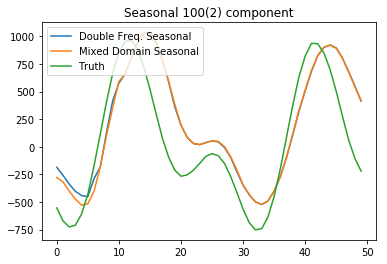

In [45]:
time_s = np.s_[:50]  # After this they basically agree
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
h21, = ax2.plot(series.index[time_s], res_f.freq_seasonal[1].filtered[time_s], label='Double Freq. Seas')
h22, = ax2.plot(series.index[time_s], res_tf.freq_seasonal[0].filtered[time_s], label='Mixed Domain Seas')
h23, = ax2.plot(series.index[time_s], true_seasonal_100_2[time_s], label='True Seasonal 100(2)')
plt.legend([h21, h22, h23], ['Double Freq. Seasonal','Mixed Domain Seasonal','Truth'], loc=2)
plt.title('Seasonal 100(2) component')

Text(0.5, 1.0, 'Seasonal components combined')

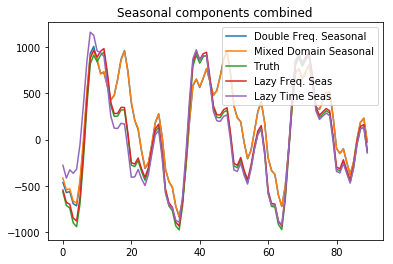

In [46]:
time_s = np.s_[:100]

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
h31, = ax3.plot(series.index[time_s], res_f.freq_seasonal[1].filtered[time_s] + res_f.freq_seasonal[0].filtered[time_s], label='Double Freq. Seas')
h32, = ax3.plot(series.index[time_s], res_tf.freq_seasonal[0].filtered[time_s] + res_tf.seasonal.filtered[time_s], label='Mixed Domain Seas')
h33, = ax3.plot(series.index[time_s], true_sum[time_s], label='True Seasonal 100(2)')
h34, = ax3.plot(series.index[time_s], res_lf.freq_seasonal[0].filtered[time_s], label='Lazy Freq. Seas')
h35, = ax3.plot(series.index[time_s], res_lt.seasonal.filtered[time_s], label='Lazy Time Seas')

plt.legend([h31, h32, h33, h34, h35], ['Double Freq. Seasonal','Mixed Domain Seasonal','Truth', 'Lazy Freq. Seas', 'Lazy Time Seas'], loc=1)
plt.title('Seasonal components combined')